# **Judging a book by it's cover**


**Navigating throught this notebook:**
1.   Importing modules
2.   Defining functions 
3.   Image Tranformation
4.   Transfer Learning VGG-16 model
     1. Downloading pre-trained model
     2. Training the model using Book train dataset using pre-trained model
     3. Select the best possible model and save it
     4. Predict the genre of the book using saved model
     5. Calculate accuracy of model
     6. Calculate the accuracy per category
5.   Trasfer Learning resnet50 model
     1. Downloading pre-trained model
     2. Training the model using Book train dataset using pre-trained model
     3. Select the best possible model and save it
     4. Predict the genre of the book using saved model
     5. Calculate accuracy of model
     6. Calculate the accuracy per category







**Importing necessary modules**

In [0]:
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
# PyTorch
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
%cd My Drive

/gdrive/My Drive


**Defining the functions**

In [0]:
# Function to display images
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [0]:
# To show how augmentation works, we need to write a function that will plot a tensor as an image.
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

In [0]:
# We can refactor all that code into a single function that returns a pretrained model. 
# This only accepts the vgg16 or resnet50 at the moment but can be extended to use other models
def get_pretrained_model(model_name):
    """Retrieve a pre-trained model from torchvision

    Params
    -------
        model_name (str): name of the model (currently only accepts vgg16 and resnet50)

    Return
    --------
        model (PyTorch model): cnn

    """

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    # Move to gpu and parallelize
    if train_on_gpu:
        model = model.to('cuda')

    if multi_gpu:
        model = nn.DataParallel(model)

    return model

In [0]:
# The below function trains the network while monitoring a number of different parameters. We train with early stopping on the validation set.
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [0]:
# The train function saves the best model state_dict() which are the weights of the model. 
# To save more information about the model, we use the below function.
def save_checkpoint(model, path):
    """Save a PyTorch model checkpoint

    Params
    --------
        model (PyTorch model): model to save
        path (str): location to save model. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    if model_name == 'vgg16':
        # Check to see if model was parallelized
        if multi_gpu:
            checkpoint['classifier'] = model.module.classifier
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['classifier'] = model.classifier
            checkpoint['state_dict'] = model.state_dict()

    elif model_name == 'resnet50':
        if multi_gpu:
            checkpoint['fc'] = model.module.fc
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['fc'] = model.fc
            checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, path)


In [0]:
# Function to load in the checkpoint. This just takes in a path and returns a model from a saved checkpoint.
def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    # Get the model name
    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Load in checkpoint
    checkpoint = torch.load(path)

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.fc = checkpoint['fc']

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')

    # Move to gpu
    if multi_gpu:
        model = nn.DataParallel(model)

    if train_on_gpu:
        model = model.to('cuda')

    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer


In [0]:
# This function processes an image path into a PyTorch tensor for predictions. 
# It applies the same transformations as was done to the validation data: cropping (center) and normalizing with means and standard deviations.
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [0]:
# The next function makes predictions on a single image. It will return the top probabilities and classes
def predict(image_path, model, topk=5):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns

    """
    real_class = image_path.split('/')[-2]

    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

In [0]:
# This function can be used to pick a random test image.
np.random.seed = 100
def random_test_image():
    """Pick a random test image from the test directory"""
    c = np.random.choice(cat_df['category'])
    root = testdir + c + '/'
    img_path = root + np.random.choice(os.listdir(root))
    return img_path




In [0]:
# This function displays the picture along with the topk predictions from the model. The title over the image displays the true class.
def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""

    # Get predictions
    img, ps, classes, y_obs = predict(image_path, model, topk)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index=classes)

    # Show the image
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax=ax)

    # Set title to be the actual class
    ax.set_title(y_obs, size=20)

    ax = plt.subplot(1, 2, 2)
    # Plot a bar plot of predictions
    result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

In [0]:
# Image identification models are usually assessed in terms of topk accuracy
#(for example the vgg16 model gets 28.41% top1 error and 9.62% top5 error on Imagenet).
# We'll assess out model by the top1 and top5 accuracy, that is, the percentage of predictions it gets exactly correct, 
# and the percentage of predictions where the real class is in the top 5 actual classes.
# The function below computes accuracy for a prediction and a target in terms of topk.
def accuracy(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [0]:
# The next function iterates through the testing set in order to make predictions for each image. It calculates performance for each category.
def evaluate(model, test_loader, criterion, topk=(1, 5)):
    """Measure the performance of a trained PyTorch model

    Params
    --------
        model (PyTorch model): trained cnn for inference
        test_loader (PyTorch DataLoader): test dataloader
        topk (tuple of ints): accuracy to measure

    Returns
    --------
        results (DataFrame): results for each category

    """

    classes = []
    losses = []
    # Hold accuracy results
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))
    i = 0

    model.eval()
    with torch.no_grad():

        # Testing loop
        for data, targets in test_loader:

            # Tensors to gpu
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            # Raw model output
            out = model(data)
            # Iterate through each example
            for pred, true in zip(out, targets):
                # Find topk accuracy
                acc_results[i, :] = accuracy(
                    pred.unsqueeze(0), true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                # Calculate the loss
                loss = criterion(pred.view(1, n_classes), true.view(1))
                losses.append(loss.item())
                i += 1

    # Send results to a dataframe and calculate average across classes
    results = pd.DataFrame(acc_results, columns=[f'top{i}' for i in topk])
    results['class'] = classes
    results['loss'] = losses
    results = results.groupby(classes).mean()

    return results.reset_index().rename(columns={'index': 'class'})

**Load dataset into notebook**


*   I have web scrapped 57000 cover images and 20 different categories of Books but due to time constraint [runtime] I have selected only 5 categories which had more number of images


In [0]:
# Define data directory and subdirectories
data_dir= 'BookData/' 
traindir = data_dir + 'train/'
validdir = data_dir + 'val/'
testdir = data_dir + 'test/' 
# Change to fit hardware
batch_size = 32

In [0]:
# Declare checkpiont names for each model
save_file_name_vgg16 = 'vgg16-transfer-4.pt'
checkpoint_path_vgg16 = 'vgg16-transfer-4.pth'

save_file_name_resnet50 = 'resnet50-transfer-4.pt'
checkpoint_path_resnet50 = 'resnet50-transfer-4.pth'



In [0]:
# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


In [0]:
# Display number of images per dataset i.e train, test and validation
# Empty lists
categories = []
n_train = []
n_valid = []
n_test = []
# Iterate through each category
for d in os.listdir(traindir):
    categories.append(d)

    # Number of each image
    train_imgs = os.listdir(traindir + d)
    valid_imgs = os.listdir(validdir + d)
    test_imgs = os.listdir(testdir + d)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))
  # Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 'n_test': n_test}).\
    sort_values('category')
cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df.head()

,category,n_train,n_valid,n_test
3,Parenting & Relationships,1420,250,250
4,Test Preparation,1381,305,300
2,Romance,1373,300,300
0,"Mystery, Thriller & Suspense",1360,310,310
1,Biographies & Memoirs,1359,320,320


In [0]:
# Number of images in train dataset
cpt = sum([len(files) for r, d, files in os.walk("BookData/train")])
print(cpt)

6893


**Image transformation**


*   I have calculated the mean and standard deviations in data exploration step but, here, I have used image net standards to normalize the image because I found that image_net standard values work best for my model.
*   When we use the images in the pre-trained network, we'll have to reshape them to 224 x 224. This is the size of Imagenet images and is therefore what the model expects. The images that are larger than this will be truncated while the smaller images will be interpolated.



In [0]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


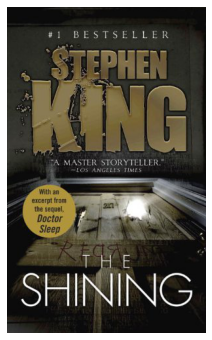

In [0]:
# Open image from train dataset
ex_img = Image.open('BookData/train/Mystery, Thriller & Suspense/0307743659.jpg')
imshow(ex_img)

<Figure size 432x432 with 0 Axes>

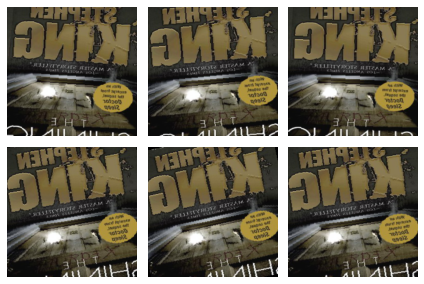

In [0]:
# Apply image transformation on traing dataset and display how image augmentation is done
t = image_transforms['train']
plt.figure(figsize=(6, 6))

for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)

plt.tight_layout()

**Data Iterator**
To avoid loading all of the data into memory at once, we use training DataLoaders. At training time, the DataLoader will load the images from disk, apply the transformations, and yield a batch. 

In [0]:
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

In [0]:
# Number of different classes in training dataset
n_classes = len(cat_df)
print(f'There are {n_classes} different classes.')

len(data['train'].classes)

There are 5 different classes.


5

In [0]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

# Transfer Learning VGG16 model
Approach
The approach for using a pre-trained image recognition model is well-established:

1. Load in pre-trained weights from a network trained on a large dataset
2. Freeze all the weights in the lower (convolutional) layers
     * Layers to freeze can be adjusted depending on similarity of task to 
       large training dataset
3. Replace the classifier (fully connected) part of the network with a    custom classifier
     * Number of outputs must be set equal to the number of classes
4. Train only the custom classifier (fully connected) layers for the task
     * Optimizer model classifier for smaller dataset


In [0]:
# Load VGG16 model with pretrained weight
model_VGG16 = models.vgg16(pretrained=True)
model_VGG16

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# Freeze early layers
for param in model_VGG16.parameters():
    param.requires_grad = False

**Add on Custom Classifier**
We'll train a classifier consisting of the following layers
1. Fully connected with ReLU activation (n_inputs, 256)
2. Dropout with 40% chance of dropping
3. Fully connected with log softmax output (256, n_classes)

To build our custom classifier, we use the nn.Sequential() module which allows us to specify each layer one after the other. We assign our custom classifier to the final classifier layer in the already trained vgg network. When we add on the extra layers, they are set to require_grad=True by default. These will be the only layers that are trained.

In [0]:
n_inputs = model_VGG16.classifier[6].in_features

# Add on classifier
model_VGG16.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

model_VGG16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=5, bias=True)
    (4): LogSoftmax()
  )
)

In [0]:
total_params = sum(p.numel() for p in model_VGG16.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model_VGG16.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,310,661 total parameters.
1,050,117 training parameters.


Even with only a few layers set to trainable, there are still over a million parameters (weights) that will be updated during training.

In [0]:
# Move to GPU
if train_on_gpu:
    model_VGG16 = model_VGG16.to('cuda')

if multi_gpu:
    model_VGG16 = nn.DataParallel(model_VGG16)

In [0]:
# This should return the same as the pretrained model with the custom classifier.
model_VGG16 = get_pretrained_model('vgg16')
if multi_gpu:
    summary(
        model_VGG16.module,
        input_size=(3, 224, 224),
        batch_size=batch_size,
        device='cuda')
else:
    summary(
        model_VGG16, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 224, 224]           1,792
              ReLU-2         [32, 64, 224, 224]               0
            Conv2d-3         [32, 64, 224, 224]          36,928
              ReLU-4         [32, 64, 224, 224]               0
         MaxPool2d-5         [32, 64, 112, 112]               0
            Conv2d-6        [32, 128, 112, 112]          73,856
              ReLU-7        [32, 128, 112, 112]               0
            Conv2d-8        [32, 128, 112, 112]         147,584
              ReLU-9        [32, 128, 112, 112]               0
        MaxPool2d-10          [32, 128, 56, 56]               0
           Conv2d-11          [32, 256, 56, 56]         295,168
             ReLU-12          [32, 256, 56, 56]               0
           Conv2d-13          [32, 256, 56, 56]         590,080
             ReLU-14          [32, 256,

In [0]:
if multi_gpu:
    print(model_VGG16.module.classifier[6])
else:
    print(model_VGG16.classifier[6])

Sequential(
  (0): Linear(in_features=4096, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=5, bias=True)
  (4): LogSoftmax()
)


In [0]:
# To keep track of the predictions made by the model, we create a mapping of classes to indexes and indexes to classes. 
# This will let us know the actual class for a given prediction.
model_VGG16.class_to_idx = data['train'].class_to_idx
model_VGG16.idx_to_class = {
    idx: class_
    for class_, idx in model_VGG16.class_to_idx.items()
}

list(model_VGG16.idx_to_class.items())[:10]

[(0, 'Biographies & Memoirs'),
 (1, 'Mystery, Thriller & Suspense'),
 (2, 'Parenting & Relationships'),
 (3, 'Romance'),
 (4, 'Test Preparation')]

**Training Loss and Optimizer**
* Loss (criterion): keeps track of the loss itself and the gradients of the loss with respect to the model parameters (weights)
* Optimizer: updates the parameters (weights) with the gradients

In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_VGG16.parameters())

In [0]:
# we can see the parameters (weights) that will be updated by the optimizer during training.
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 4096])
torch.Size([256])
torch.Size([5, 256])
torch.Size([5])


In [0]:
# Train the model using our train dataset
model_trained_VGG16, history = train(
    model_VGG16,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name_vgg16,
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2)

Starting Training from Scratch.


Epoch: 1 	Training Loss: 1.0555 	Validation Loss: 1.0935
		Training Accuracy: 58.38%	 Validation Accuracy: 56.97%

Epoch: 3 	Training Loss: 0.9962 	Validation Loss: 1.0695
		Training Accuracy: 61.32%	 Validation Accuracy: 60.07%

Epoch: 5 	Training Loss: 0.9724 	Validation Loss: 1.0857
		Training Accuracy: 61.42%	 Validation Accuracy: 58.65%

Epoch: 7 	Training Loss: 0.9421 	Validation Loss: 1.0521
		Training Accuracy: 62.93%	 Validation Accuracy: 59.87%

Epoch: 9 	Training Loss: 0.9191 	Validation Loss: 1.0750
		Training Accuracy: 63.77%	 Validation Accuracy: 57.85%

Epoch: 11 	Training Loss: 0.9063 	Validation Loss: 1.0975
		Training Accuracy: 64.59%	 Validation Accuracy: 57.37%

Early Stopping! Total epochs: 12. Best epoch: 7 with loss: 1.05 and acc: 59.60%
4651.32 total seconds elapsed. 357.79 seconds per epoch.


<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

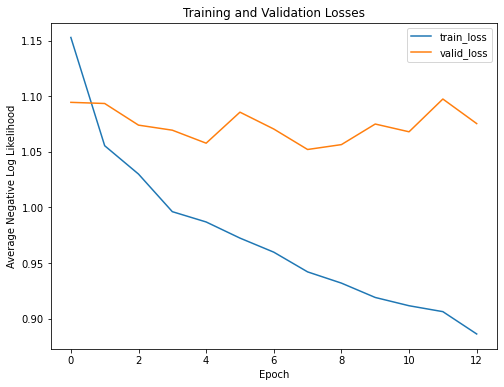

In [0]:
# inspect the training progress by looking at the history.
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

As expected, the training loss decreases continually with epochs. At a certain point however, the validation loss decreases. There is not a massive amount of overfitting, likely because we were using Dropout. With the divergence in losses, there is likely not much more to gain from further training.

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

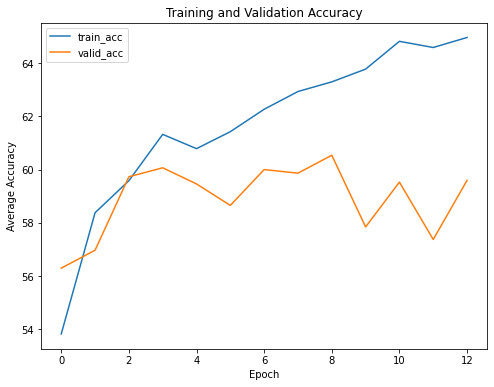

In [0]:
# Draw accuracy
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

As with the losses, the training accuracy increases while the validation accuracy fluctuate. The model is able to achieve above 60% accuracy right away, an indication that the convolution weights learned on Imagenet were able to easily transfer to our dataset.

In [0]:
#  save more information about the model, we use the below function.
save_checkpoint(model_trained_VGG16, path=checkpoint_path_vgg16)

In [0]:
# Loading checkpinot. It just takes in a path and returns a model from a saved checkpoint.
model_trained_VGG16, optimizer = load_checkpoint(path=checkpoint_path_vgg16)

if multi_gpu:
    summary(model_trained_VGG16.module, input_size=(3, 224, 224), batch_size=batch_size)
else:
    summary(model_trained_VGG16, input_size=(3, 224, 224), batch_size=batch_size)

135,310,661 total parameters.
1,050,117 total gradient parameters.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 224, 224]           1,792
              ReLU-2         [32, 64, 224, 224]               0
            Conv2d-3         [32, 64, 224, 224]          36,928
              ReLU-4         [32, 64, 224, 224]               0
         MaxPool2d-5         [32, 64, 112, 112]               0
            Conv2d-6        [32, 128, 112, 112]          73,856
              ReLU-7        [32, 128, 112, 112]               0
            Conv2d-8        [32, 128, 112, 112]         147,584
              ReLU-9        [32, 128, 112, 112]               0
        MaxPool2d-10          [32, 128, 56, 56]               0
           Conv2d-11          [32, 256, 56, 56]         295,168
             ReLU-12          [32, 256, 56, 56]               0
           Conv2d-13          [32, 2

In [0]:
# We can now use these two functions to save and load in a complete model. We can use this model to continue training.
model_trained_final_VGG16, history = train(
    model_trained_VGG16,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name_vgg16,
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2)

Model has been trained for: 13 epochs.


Epoch: 1 	Training Loss: 0.9050 	Validation Loss: 1.0697
		Training Accuracy: 64.69%	 Validation Accuracy: 59.73%

Epoch: 3 	Training Loss: 0.8865 	Validation Loss: 1.0888
		Training Accuracy: 65.57%	 Validation Accuracy: 59.26%

Epoch: 5 	Training Loss: 0.8753 	Validation Loss: 1.0628
		Training Accuracy: 66.02%	 Validation Accuracy: 60.67%

Early Stopping! Total epochs: 5. Best epoch: 0 with loss: 1.06 and acc: 60.67%
473.92 total seconds elapsed. 78.99 seconds per epoch.


In [0]:
#  processes an image path into a PyTorch tensor for predictions
x = process_image(testdir + 'Romance/006056251X.jpg')
x.shape

torch.Size([3, 224, 224])

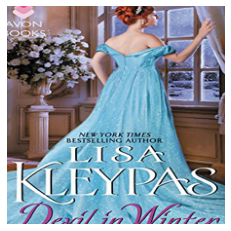

In [0]:
ax, image = imshow_tensor(x)

**Predicting on test data using VGG16 model**

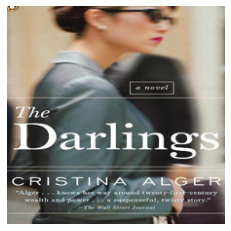

In [0]:
# predicting on single random test image
_ = imshow_tensor(process_image(random_test_image()))

In [0]:
img, top_p, top_classes, real_class = predict(random_test_image(), model_trained_final_VGG16)
img.shape

torch.Size([3, 224, 224])

In [0]:
top_p, top_classes, real_class

(array([9.8029685e-01, 1.6061297e-02, 1.8757484e-03, 1.6303858e-03,
        1.3570212e-04], dtype=float32),
 ['Test Preparation',
  'Parenting & Relationships',
  'Mystery, Thriller & Suspense',
  'Biographies & Memoirs',
  'Romance'],
 'Test Preparation')

In [0]:
img, top_p, top_classes, real_class = predict(random_test_image(), model_trained_final_VGG16)
top_p, top_classes, real_class

(array([0.6023726 , 0.19034424, 0.1032842 , 0.09035255, 0.01364641],
       dtype=float32),
 ['Test Preparation',
  'Biographies & Memoirs',
  'Mystery, Thriller & Suspense',
  'Parenting & Relationships',
  'Romance'],
 'Biographies & Memoirs')

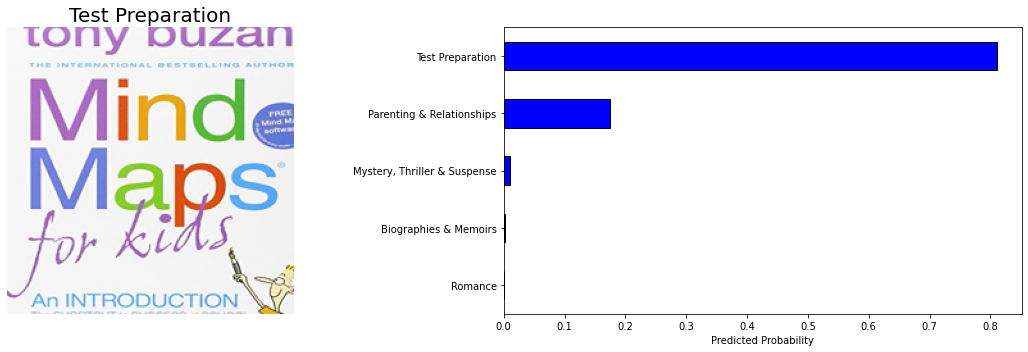

In [0]:
# displays the picture along with the topk predictions from the model. The title over the image displays the true class
display_prediction(random_test_image(), model_trained_final_VGG16, topk=5)

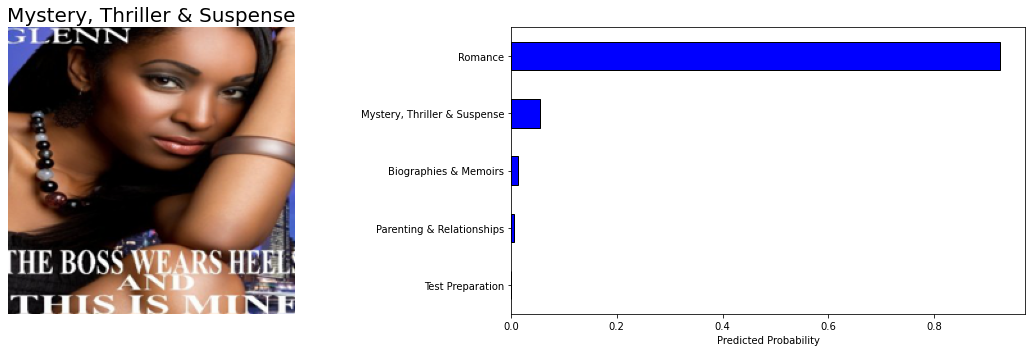

In [0]:
display_prediction(random_test_image(), model_trained_final_VGG16, topk=5)

**Test Results**

In [0]:
# accuracy for a prediction and a target in terms of topk.
testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)

if train_on_gpu:
    accuracy(model_trained_final_VGG16(features.to('cuda')), targets, topk=(1, 5))
else:
    accuracy(model_trained_final_VGG16(features), targets, topk=(1, 5))


[59.375, 100.0]

In [0]:
# iterate through the testing set in order to make predictions for each image and calculates performance for each category.
criterion = nn.NLLLoss()
# Evaluate the model on all the training data
results_VGG16 = evaluate(model_trained_final_VGG16, dataloaders['test'], criterion)
results_VGG16.head()

,class,top1,top5,loss
0,Biographies & Memoirs,50.937500,100.0,1.199545
1,"Mystery, Thriller & Suspense",66.451613,100.0,1.045316
2,Parenting & Relationships,54.400000,100.0,1.129545
3,Romance,57.666667,100.0,1.151498
4,Test Preparation,70.666667,100.0,0.776581


So we can see that the category Biographies & Memoirs has the least accuracy 

And from as we can see from cat_df.head() the category 'Biographies & Memoirs' has less number of images. So we can say that our model works well on the categories which has more number of images 

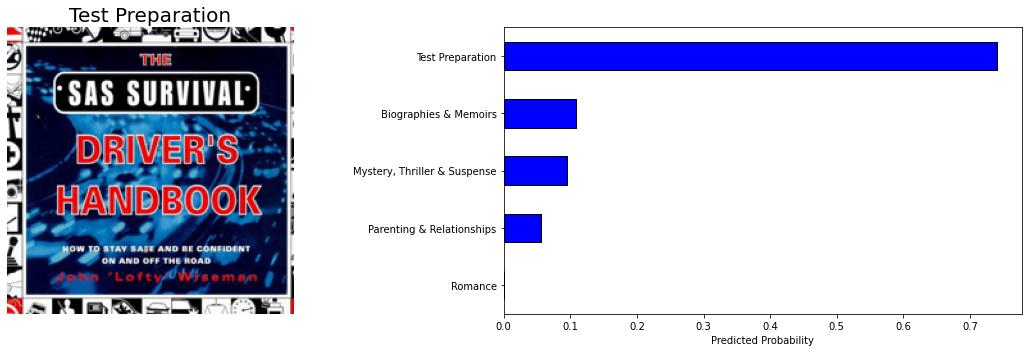

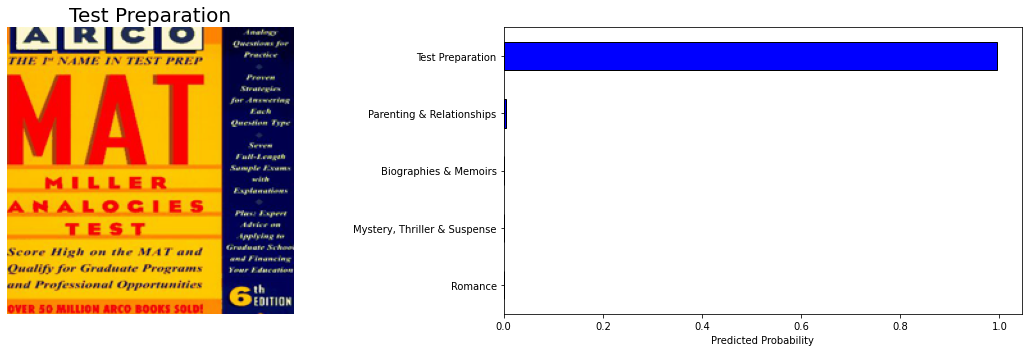

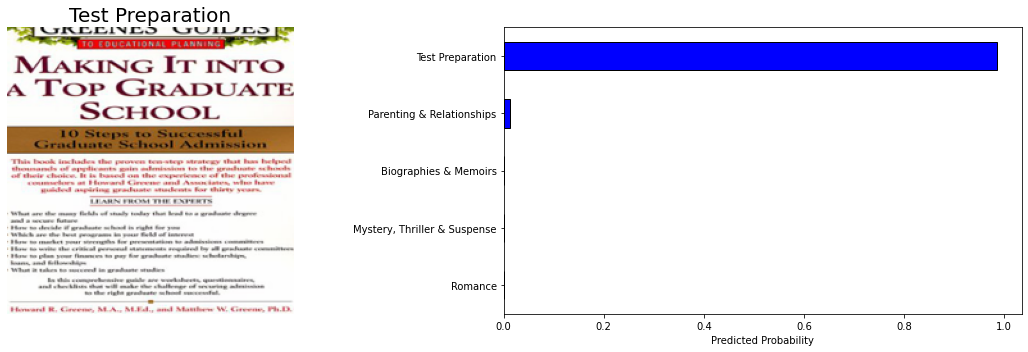

In [0]:
TestPreparation1 = testdir + 'Test Preparation/0002558327.jpg'
TestPreparation2 = testdir+ 'Test Preparation/0028603192.jpg'
TestPreparation3 = testdir+ 'Test Preparation/0060934581.jpg'

display_prediction(TestPreparation1, model_trained_final_VGG16 , 5)
display_prediction(TestPreparation2, model_trained_final_VGG16, 5)
display_prediction(TestPreparation3, model_trained_final_VGG16, 5)

**So it looks like our model is successful in predicting the catory of 3 given images**

# Transfer Learning Resnet50 model


In [0]:
# Load VGG16 model with pretrained weight
model_resnet = models.resnet50(pretrained=True)
model_resnet

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
# Freeze early layers
for param in model_resnet.parameters():
    param.requires_grad = False

**Add on Custom Classifier**
We'll train a classifier consisting of the following layers
1. Fully connected with ReLU activation (n_inputs, 256)
2. Dropout with 40% chance of dropping
3. Fully connected with log softmax output (256, n_classes)

To build our custom classifier, we use the nn.Sequential() module which allows us to specify each layer one after the other. We assign our custom classifier to the final classifier layer in the already trained vgg network. When we add on the extra layers, they are set to require_grad=True by default. These will be the only layers that are trained.

In [0]:
total_params = sum(p.numel() for p in model_resnet.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model_resnet.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

25,557,032 total parameters.
0 training parameters.


Even with only a few layers set to trainable, there are still over a million parameters (weights) that will be updated during training.

In [0]:
# Move to GPU
if train_on_gpu:
    model_resnet = model_resnet.to('cuda')

if multi_gpu:
    model_resnet = nn.DataParallel(model_resnet)

In [0]:
# This should return the same as the pretrained model with the custom classifier.
model_resnet = get_pretrained_model('resnet50')
if multi_gpu:
    summary(
        model_resnet.module,
        input_size=(3, 224, 224),
        batch_size=batch_size,
        device='cuda')
else:
    summary(
        model_resnet, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,408
       BatchNorm2d-2         [32, 64, 112, 112]             128
              ReLU-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5           [32, 64, 56, 56]           4,096
       BatchNorm2d-6           [32, 64, 56, 56]             128
              ReLU-7           [32, 64, 56, 56]               0
            Conv2d-8           [32, 64, 56, 56]          36,864
       BatchNorm2d-9           [32, 64, 56, 56]             128
             ReLU-10           [32, 64, 56, 56]               0
           Conv2d-11          [32, 256, 56, 56]          16,384
      BatchNorm2d-12          [32, 256, 56, 56]             512
           Conv2d-13          [32, 256, 56, 56]          16,384
      BatchNorm2d-14          [32, 256,

In [0]:
# To keep track of the predictions made by the model, we create a mapping of classes to indexes and indexes to classes. 
# This will let us know the actual class for a given prediction.
model_resnet.class_to_idx = data['train'].class_to_idx
model_resnet.idx_to_class = {
    idx: class_
    for class_, idx in model_resnet.class_to_idx.items()
}

list(model_resnet.idx_to_class.items())[:10]

[(0, 'Biographies & Memoirs'),
 (1, 'Mystery, Thriller & Suspense'),
 (2, 'Parenting & Relationships'),
 (3, 'Romance'),
 (4, 'Test Preparation')]

**Training Loss and Optimizer**
* Loss (criterion): keeps track of the loss itself and the gradients of the loss with respect to the model parameters (weights)
* Optimizer: updates the parameters (weights) with the gradients

In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_resnet.parameters())

In [0]:
# we can see the parameters (weights) that will be updated by the optimizer during training.
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 2048])
torch.Size([256])
torch.Size([5, 256])
torch.Size([5])


In [0]:
# Train the model using our train dataset
model_trained_resnet, history = train(
    model_resnet,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name_resnet50,
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2)

Starting Training from Scratch.


Epoch: 1 	Training Loss: 1.0436 	Validation Loss: 1.0569
		Training Accuracy: 58.71%	 Validation Accuracy: 60.13%

Epoch: 3 	Training Loss: 0.9801 	Validation Loss: 1.0916
		Training Accuracy: 61.58%	 Validation Accuracy: 57.64%

Epoch: 5 	Training Loss: 0.9706 	Validation Loss: 1.0388
		Training Accuracy: 62.21%	 Validation Accuracy: 60.07%

Epoch: 7 	Training Loss: 0.9349 	Validation Loss: 1.0212
		Training Accuracy: 63.93%	 Validation Accuracy: 60.54%

Epoch: 9 	Training Loss: 0.9176 	Validation Loss: 1.0119
		Training Accuracy: 64.40%	 Validation Accuracy: 62.49%

Epoch: 11 	Training Loss: 0.9045 	Validation Loss: 1.0487
		Training Accuracy: 64.78%	 Validation Accuracy: 60.13%

Epoch: 13 	Training Loss: 0.9014 	Validation Loss: 1.0388
		Training Accuracy: 64.94%	 Validation Accuracy: 61.48%

Early Stopping! Total epochs: 14. Best epoch: 9 with loss: 1.01 and acc: 61.08%
1076.35 total seconds elapsed. 71.76 seconds per epoch.


<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

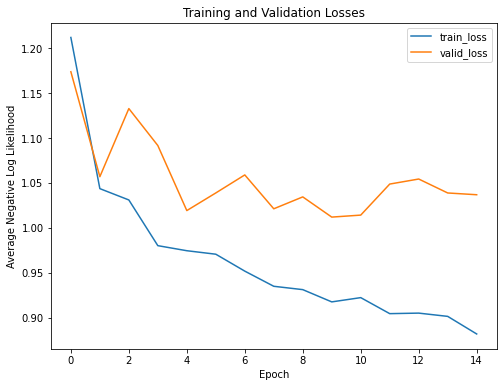

In [0]:
# inspect the training progress by looking at the history.
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

As expected, the training loss decreases continually with epochs. At a certain point however, the validation loss decreases. There is not a massive amount of overfitting, likely because we were using Dropout. With the divergence in losses, there is likely not much more to gain from further training.

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

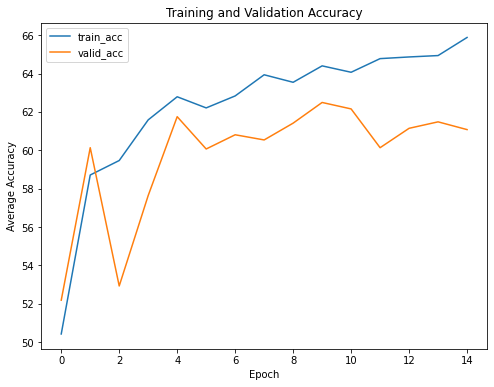

In [0]:
# Draw accuracy
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

As with the losses, the training accuracy increases while the validation accuracy fluctuate. The model is able to achieve above 60% accuracy right away, an indication that the convolution weights learned on Imagenet were able to easily transfer to our dataset.

In [0]:
#  save more information about the model, we use the below function.
save_checkpoint(model_trained_resnet, path=checkpoint_path_resnet50)

In [0]:
# Loading checkpinot. It just takes in a path and returns a model from a saved checkpoint.
model_trained_resnet, optimizer = load_checkpoint(path=checkpoint_path_resnet50)

if multi_gpu:
    summary(model_trained_resnet.module, input_size=(3, 224, 224), batch_size=batch_size)
else:
    summary(model_trained_resnet, input_size=(3, 224, 224), batch_size=batch_size)

24,033,861 total parameters.
525,829 total gradient parameters.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,408
       BatchNorm2d-2         [32, 64, 112, 112]             128
              ReLU-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5           [32, 64, 56, 56]           4,096
       BatchNorm2d-6           [32, 64, 56, 56]             128
              ReLU-7           [32, 64, 56, 56]               0
            Conv2d-8           [32, 64, 56, 56]          36,864
       BatchNorm2d-9           [32, 64, 56, 56]             128
             ReLU-10           [32, 64, 56, 56]               0
           Conv2d-11          [32, 256, 56, 56]          16,384
      BatchNorm2d-12          [32, 256, 56, 56]             512
           Conv2d-13          [32, 256,

In [0]:
# We can now use these two functions to save and load in a complete model. We can use this model to continue training.
model_trained_final_resnet, history = train(
    model_trained_resnet,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name_resnet50,
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2)

Model has been trained for: 15 epochs.


Epoch: 1 	Training Loss: 0.9191 	Validation Loss: 1.0518
		Training Accuracy: 63.92%	 Validation Accuracy: 59.39%

Epoch: 3 	Training Loss: 0.9097 	Validation Loss: 1.0756
		Training Accuracy: 64.63%	 Validation Accuracy: 58.86%

Epoch: 5 	Training Loss: 0.8720 	Validation Loss: 1.0408
		Training Accuracy: 65.98%	 Validation Accuracy: 61.48%

Epoch: 7 	Training Loss: 0.8815 	Validation Loss: 1.0487
		Training Accuracy: 65.79%	 Validation Accuracy: 60.20%

Early Stopping! Total epochs: 7. Best epoch: 2 with loss: 1.01 and acc: 60.20%
563.99 total seconds elapsed. 70.50 seconds per epoch.


In [0]:
#  processes an image path into a PyTorch tensor for predictions
x = process_image(testdir + 'Romance/006056251X.jpg')
x.shape

torch.Size([3, 224, 224])

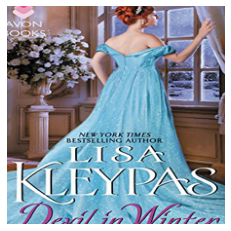

In [0]:
ax, image = imshow_tensor(x)

**Predicting on test data using VGG16 model**

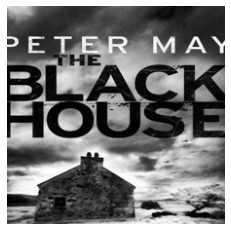

In [0]:
# predicting on single random test image
_ = imshow_tensor(process_image(random_test_image()))

In [0]:
img, top_p, top_classes, real_class = predict(random_test_image(), model_trained_final_resnet)
img.shape

torch.Size([3, 224, 224])

In [0]:
top_p, top_classes, real_class

(array([0.4127783 , 0.22949153, 0.15800983, 0.12114295, 0.07857732],
       dtype=float32),
 ['Mystery, Thriller & Suspense',
  'Biographies & Memoirs',
  'Test Preparation',
  'Romance',
  'Parenting & Relationships'],
 'Mystery, Thriller & Suspense')

In [0]:
img, top_p, top_classes, real_class = predict(random_test_image(), model_trained_final_resnet)
top_p, top_classes, real_class

(array([0.59395117, 0.24348266, 0.07431103, 0.05315075, 0.03510429],
       dtype=float32),
 ['Biographies & Memoirs',
  'Parenting & Relationships',
  'Mystery, Thriller & Suspense',
  'Romance',
  'Test Preparation'],
 'Biographies & Memoirs')

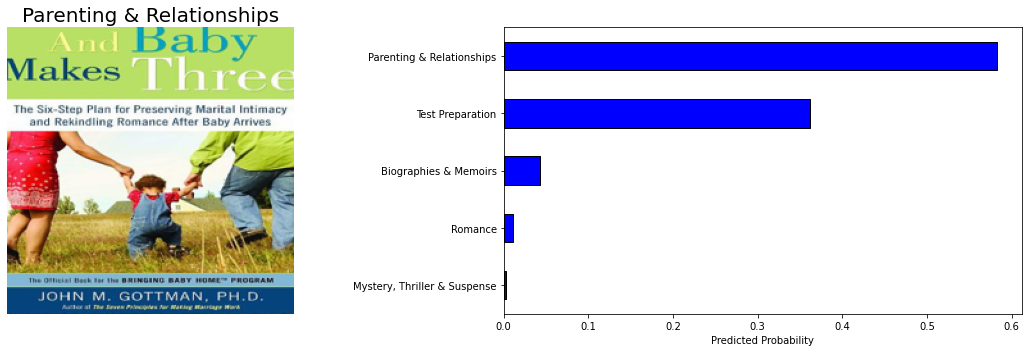

In [0]:
# displays the picture along with the topk predictions from the model. The title over the image displays the true class
display_prediction(random_test_image(), model_trained_final_resnet, topk=5)

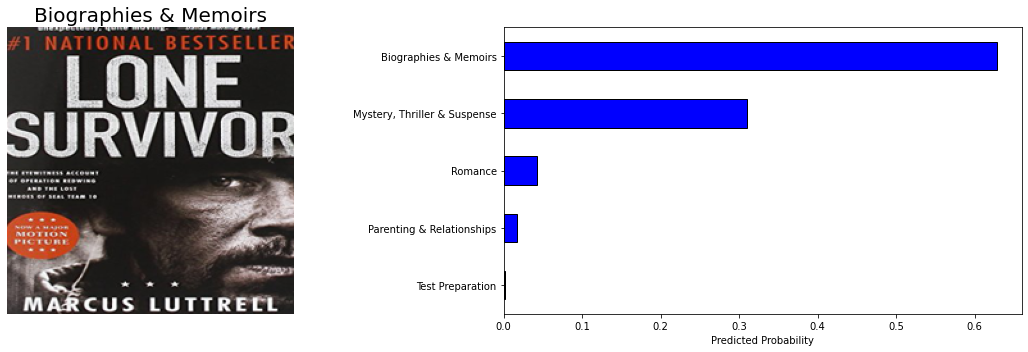

In [0]:
display_prediction(random_test_image(), model_trained_final_resnet, topk=5)

**Test Results**

In [0]:
# accuracy for a prediction and a target in terms of topk.
testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)

if train_on_gpu:
    accuracy(model_trained_final_resnet(features.to('cuda')), targets, topk=(1, 5))
else:
    accuracy(model_trained_final_resnet(features), targets, topk=(1, 5))


[62.5, 100.0]

In [0]:
# iterate through the testing set in order to make predictions for each image and calculates performance for each category.
criterion = nn.NLLLoss()
# Evaluate the model on all the training data
results_resnet = evaluate(model_trained_final_resnet, dataloaders['test'], criterion)
results_resnet.head()

,class,top1,top5,loss
0,Biographies & Memoirs,69.062500,100.0,0.916479
1,"Mystery, Thriller & Suspense",60.322581,100.0,1.104819
2,Parenting & Relationships,57.200000,100.0,1.142326
3,Romance,53.666667,100.0,1.167043
4,Test Preparation,72.666667,100.0,0.753208


So we can see that the category Romance has the least accuracy 

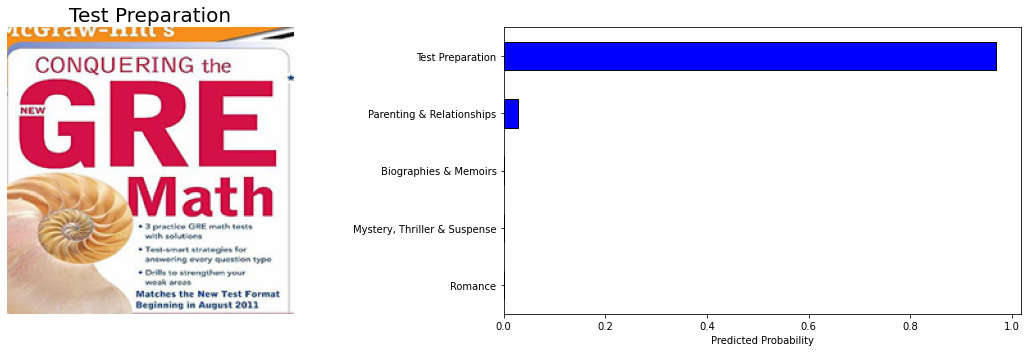

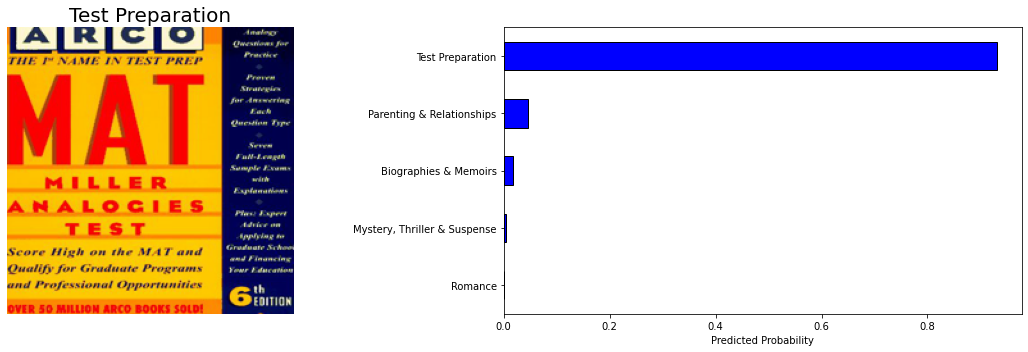

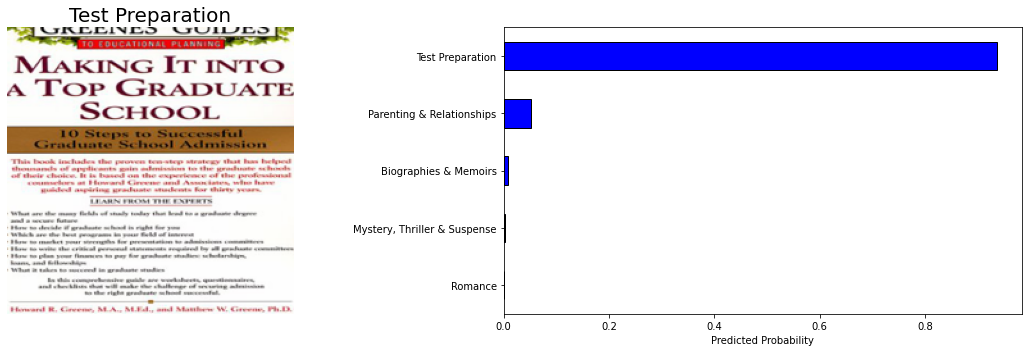

In [0]:
TestPreparation1 = testdir + 'Test Preparation/0071495959.jpg'
TestPreparation2 = testdir+ 'Test Preparation/0028603192.jpg'
TestPreparation3 = testdir+ 'Test Preparation/0060934581.jpg'

display_prediction(TestPreparation1, model_trained_final_resnet , 5)
display_prediction(TestPreparation2, model_trained_final_resnet, 5)
display_prediction(TestPreparation3, model_trained_final_resnet, 5)

**So, our resnet model also predicted correct category for all the 3 cover images**